1319


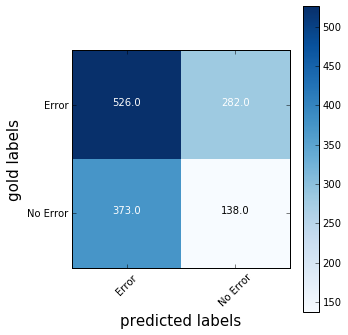

defaultdict(<class 'int'>, {(0, 1): 373, (1, 0): 282, (0, 0): 138, (1, 1): 526})


In [12]:
from collections import defaultdict
import csv
import fce_api as fd
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import settings


def full_evaluation_table(confusion_matrix, classes=[]):
    """
    Produce a pandas data-frame with Precision, F1 and Recall for all labels.
    Args:
        confusion_matrix: the confusion matrix to calculate metrics from.
        classes: the categories of the confusion matrix
        
    Returns:
        a pandas Dataframe with one row per gold label, and one more row for the aggregate of all labels.
    """
    labels = sorted(list({l for l, _ in confusion_matrix.keys()} | {l for _, l in confusion_matrix.keys()}))
    gold_counts = defaultdict(int)
    guess_counts = defaultdict(int)
    for (gold_label, guess_label), count in confusion_matrix.items():
        if gold_label != "None":
            gold_counts[gold_label] += count
            gold_counts["[All]"] += count
        if guess_label != "None":
            guess_counts[guess_label] += count
            guess_counts["[All]"] += count

    result_table = []
    for label in labels:
        if label != "None":
            if len(classes) == len(labels):
                result_table.append((classes[label], gold_counts[label], guess_counts[label], *evaluate(confusion_matrix, {label})))
            else:
                result_table.append((label, gold_counts[label], guess_counts[label], *evaluate(confusion_matrix, {label})))
    result_table.append(("[All]", gold_counts["[All]"], guess_counts["[All]"], *evaluate(confusion_matrix)))
    return pd.DataFrame(result_table, columns=('Label', 'Gold', 'Guess', 'Precision', 'Recall', 'F1'))


def evaluate(conf_matrix, label_filter=None):
    """
    Evaluate Precision, Recall and F1 based on a confusion matrix as produced by `create_confusion_matrix`.
    Args:
        conf_matrix: a confusion matrix in form of a dictionary from `(gold_label,guess_label)` pairs to counts.
        label_filter: a set of gold labels to consider. If set to `None` all labels are considered.

    Returns:
        Precision, Recall, F1 triple.
    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for (gold, guess), count in conf_matrix.items():
        if label_filter is None or gold in label_filter or guess in label_filter:
            if gold == 'None' and guess != gold:
                fp += count
            elif gold == 'None' and guess == gold:
                tn += count
            elif gold != 'None' and guess == gold:
                tp += count
            elif gold != 'None' and guess == 'None':
                fn += count
            else:  # both gold and guess are not-None, but different
                fp += count if label_filter is None or guess in label_filter else 0
                fn += count if label_filter is None or gold in label_filter else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec * recall > 0 else 0.0
    return prec, recall, f1

# if the number of annotations is at least number judgements
def test_annotation_dict(annot_dict, judgements):
    for key in annot_dict.keys():
        if len(annot_dict[key]) < judgements:
            return False
    return True

# create the confusion matrix
def create_confusion_matrix(data, predictions):
    """
    Produces a confusion matrix in a form of a dictionary from (gold_label,guess_label)` pairs to counts.
    Args:
        data: list containing the gold labels.
        predictions: list containing the prediction labels

    Returns:
        confusion matrix in form of dictionary with counts for (gold_label, guess_label)
    """
    confusion = defaultdict(int)
    for y_gold, y_guess in zip(data, predictions):
        confusion[(y_gold, y_guess)] += 1
    return confusion

# plot the confusion matrix
def plot_confusion_matrix_dict(matrix_dict, classes=[], rotation=45, outside_label=''):
    labels = set([y for y, _ in matrix_dict.keys()] + [y for _, y in matrix_dict.keys()])
    sorted_labels = sorted(labels, key=lambda x: -x)
    matrix = np.zeros((len(sorted_labels), len(sorted_labels)))
    for i1, y1 in enumerate(sorted_labels):
        for i2, y2 in enumerate(sorted_labels):
            if y1 != outside_label or y2 != outside_label:
                matrix[i1, i2] = matrix_dict[y1, y2]

    threshold = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > threshold else "black")

    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    if (len(classes) != len(sorted_labels)):
        classes = sorted_labels
        SMALL_SIZE = 14
#     MEDIUM_SIZE = 15
#     BIGGER_SIZE = 20
        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation)
    plt.yticks(tick_marks, classes)
    plt.xlabel('predicted labels')
    plt.ylabel('gold labels')
    fig_size = (5, 5)
    plt.rcParams["figure.figsize"] = fig_size
    plt.tight_layout()
    plt.show()

# extracts the amt_sentences along with their errors
def extract_sentences_with_errors():
    # open source file
    with open(settings.TRAINING_DATA_FILE, 'r') as file:
        # read the lines
        readlines = file.readlines()
        with open('amt_sentence_batch.csv', 'r') as amt_batch:
            csv_reader = csv.DictReader(amt_batch)
            with open('fce_amt.experiment_two.max.rasp.m2', 'w+') as destination:
                for row in csv_reader:
                    sentence = row['sentence']
                    i = 0
                    while i < len(readlines):
                        if sentence == readlines[i][2:-1]:
                            destination.write(readlines[i])
                            i += 1
                            while readlines[i][0] != 'S' and i < len(readlines):
                                destination.writelines(readlines[i])
                                i += 1
                        else:
                            i += 1


# get annotations from turkers
def get_annotations():
    # sentence -> annotations
    result_annotations = defaultdict(list)
    with open(settings.AMT_FILE) as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            sentence = row['Input.sentence']
            answer = json.loads(row['Answer.ChosenWord'])
            for annotation in answer['selectedTokens']:
                result_annotations[sentence].append(annotation['start'])
    return result_annotations

# compare the annotations with gold
def compare_annotations(gold_sentences, annotation_labels):
    """
    Produces gold and annotation error detection labels from given annotations and gold data
    Args:
        gold_sentences: a list  of tuples containing the sentences and the related gold error annotations.
        annotation_labels: labels from the annotation representing the start index of the error

    Returns:
        gold and predicted labels
    """
    gold = []
    predicted = []
    count = 0
    for sentence in gold_sentences:
        labels = annotations[sentence[0][1:]]
        for label in labels:
            counted = 0
            error_spans = sentence[1]
            if label == - 2 and len(error_spans) == 0:
                gold.append(0)
                predicted.append(0)
                counted = 1
            if label == -2 and len(error_spans) > 0:
                gold.append(1)
                predicted.append(0)
                counted = 1
            for error_span in error_spans:
                if int(label) >= error_span[0] and int(label) < error_span[1]:
                    gold.append(1)
                    predicted.append(1)
                    counted = 1
            if (counted == 0):
                gold.append(0)
                predicted.append(1)
                counted = 1
    return gold, predicted


if __name__ == '__main__':
    gold_data = fd.extract_data('fce_amt.experiment_two.max.rasp.m2')
    annotations = get_annotations()
    gold, predicted = compare_annotations(gold_data, annotations)
    print(len(gold))
    cm = create_confusion_matrix(gold, predicted)
    plot_confusion_matrix_dict(cm, classes=['Error', 'No Error'])
    precision_and_recall = full_evaluation_table(cm, classes=['No Error', 'Error'])
    print(cm)
    precision_and_recall

In [1]:
precision_and_recall

NameError: name 'precision_and_recall' is not defined

In [14]:
twod = [[1, 2, 3], [4, 5, 6]]
print(len(twod))

2


In [15]:
[0] * 5

[0, 0, 0, 0, 0]